Deferred to SaggeMaker for creation of filtered file

Import Reviews csv and NFL Data xlsx

In [ ]:
import pandas as pd

# Read in reviews data (no text version, just sentiment polarity scores)
review_sentiment_df = pd.read_csv("/content/notext_filtered_reviews.csv")

# Remove each entry where state = PA
review_sentiment_df = review_sentiment_df[review_sentiment_df['state'] != 'PA']

In [ ]:
# Read in nfl data (excel file)
nfl_df = pd.read_excel("/content/NFLSeasonData.xlsx")

In [ ]:
# Check which states are included in analysis

unique_values = review_sentiment_df['state'].unique()
print(unique_values)

['AZ' 'LA' 'MO' 'IN' 'TN' 'IL']


Create columns indicating season start year for NFL as well as off/on-season qualifier

In [ ]:
import pandas as pd

# Ensure the 'date' column is in datetime format
review_sentiment_df['date'] = pd.to_datetime(review_sentiment_df['date'])

def assign_season_info(review_date):
    """
    Given a review_date, returns a tuple:
    (season_start_year, season_period)

    Off-season: April 1 - July 31 of a given year.
    On-season: August 1 of a given year - March 31 of the next year.
    """
    month = review_date.month
    year = review_date.year
    # Off-season: April to July => season for that same year.
    if 4 <= month <= 7:
        return year, 'off-season'
    # On-season: August to December => season for that year.
    elif 8 <= month <= 12:
        return year, 'on-season'
    # On-season: January to March => season started in previous year.
    else:  # month in [1, 2, 3]
        return year - 1, 'on-season'

# Apply the function to each date in the DataFrame
review_sentiment_df[['season_start_year', 'season_period']] = review_sentiment_df['date'].apply(
    lambda d: pd.Series(assign_season_info(d))
)

# Verify the results by displaying a few rows
print(review_sentiment_df[['date', 'season_start_year', 'season_period']].head())


                 date  season_start_year season_period
0 2014-02-05 20:30:30               2013     on-season
1 2017-01-14 20:54:15               2016     on-season
3 2014-06-27 22:44:01               2014    off-season
5 2011-10-27 17:12:05               2011     on-season
7 2014-11-12 14:12:20               2014     on-season


Run some basic exploratory analysis

State-Year Aggregated Data:
  state  season_start_year  avg_sentiment  review_count
0    AZ               2004       0.520612            17
1    AZ               2005       0.672798            52
2    AZ               2006       0.602961           137
3    AZ               2007       0.626554           447
4    AZ               2008       0.687359          1104


<Figure size 1200x800 with 0 Axes>

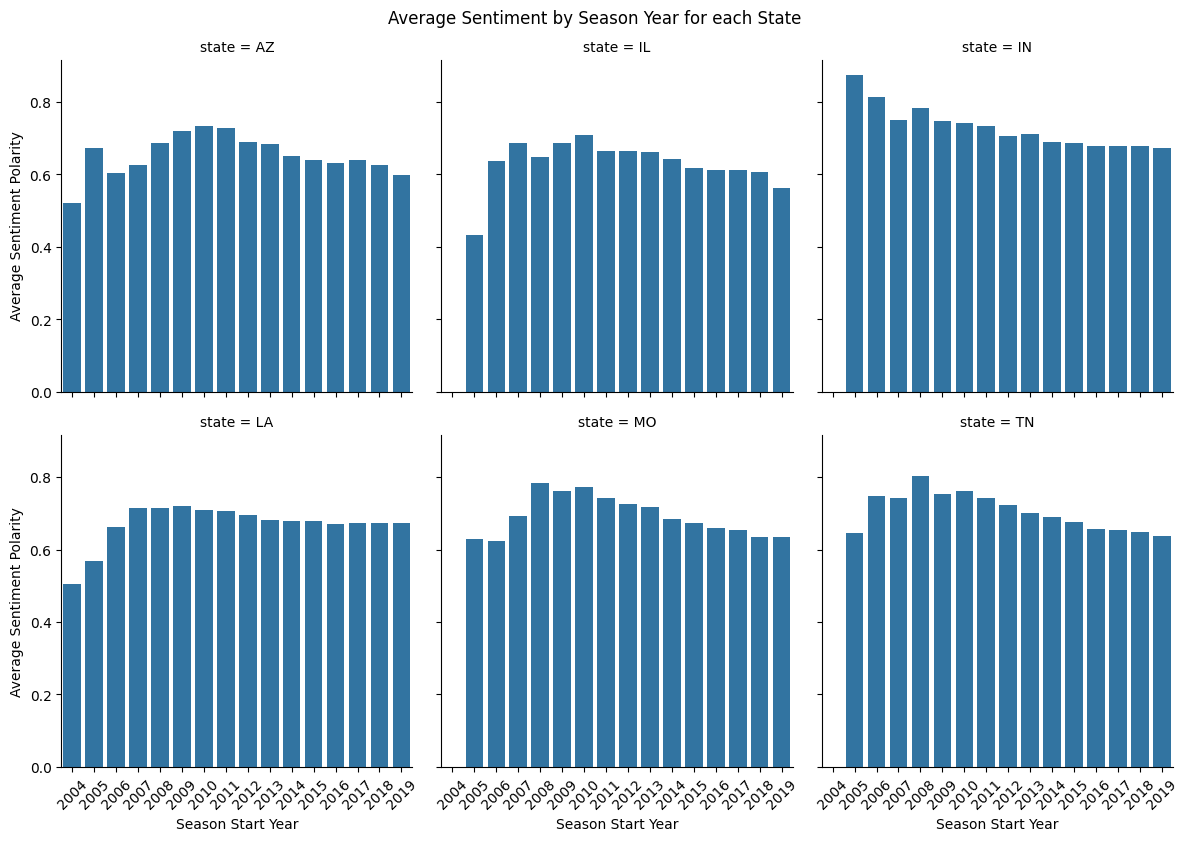

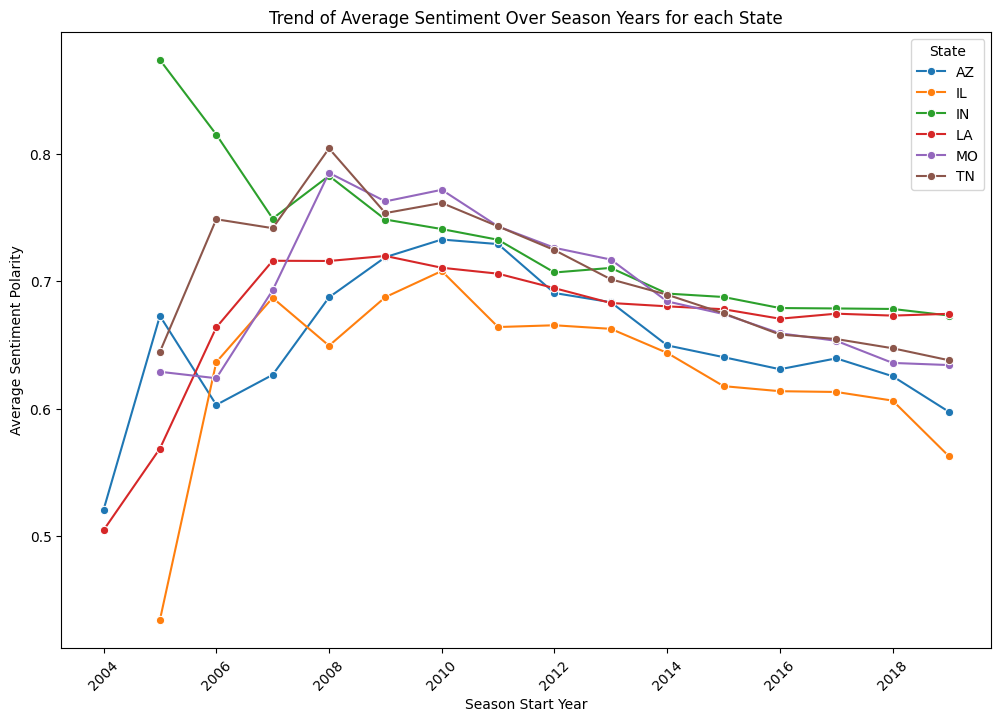

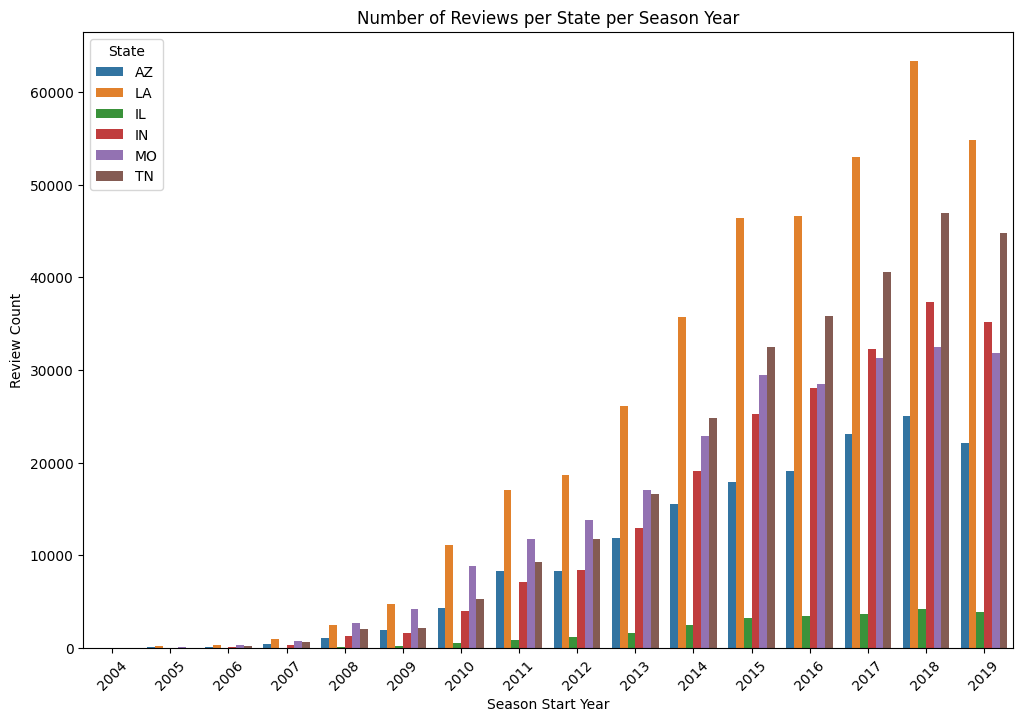

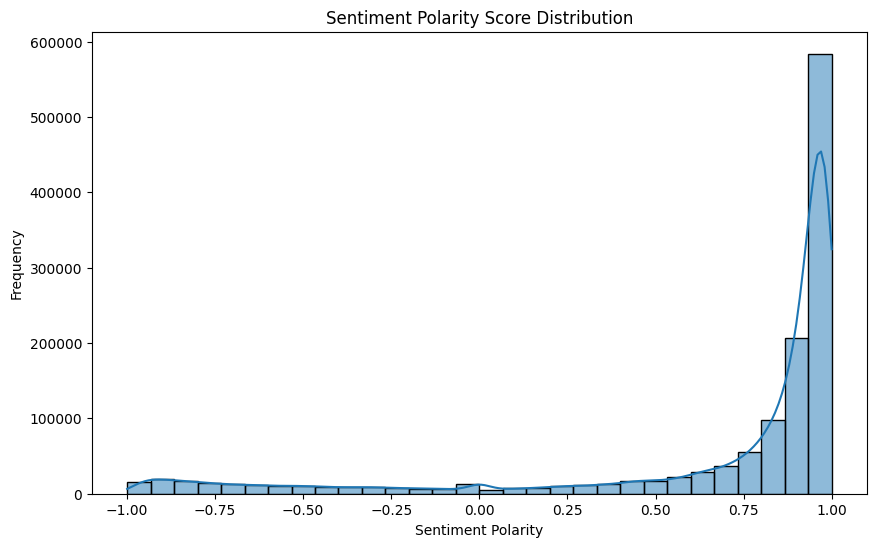

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'season_start_year' is numeric (if not already)
review_sentiment_df['season_start_year'] = review_sentiment_df['season_start_year'].astype(int)

# --------------------------
# 1. Grouping Data by State and Season Year
# --------------------------
state_year_sentiment = review_sentiment_df.groupby(['state', 'season_start_year']).agg(
    avg_sentiment=('sentiment_polarity', 'mean'),
    review_count=('review_id', 'count')
).reset_index()

print("State-Year Aggregated Data:")
print(state_year_sentiment.head())

# --------------------------
# 2. Faceted Bar Plot: Average Sentiment by Season Year for each State
# --------------------------
plt.figure(figsize=(12, 8))
# Create a FacetGrid with one subplot per state
g = sns.FacetGrid(state_year_sentiment, col='state', col_wrap=3, height=4, sharey=True)
# Use barplot for each facet; order the x-axis by season_start_year
g.map(sns.barplot, 'season_start_year', 'avg_sentiment', order=sorted(review_sentiment_df['season_start_year'].unique()))
g.fig.suptitle("Average Sentiment by Season Year for each State", y=1.02)
g.set_axis_labels("Season Start Year", "Average Sentiment Polarity")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)
plt.show()

# --------------------------
# 3. Line Plot: Trend of Average Sentiment Over Season Years for Each State
# --------------------------
plt.figure(figsize=(12, 8))
sns.lineplot(data=state_year_sentiment, x='season_start_year', y='avg_sentiment', hue='state', marker='o')
plt.title("Trend of Average Sentiment Over Season Years for each State")
plt.xlabel("Season Start Year")
plt.ylabel("Average Sentiment Polarity")
plt.legend(title='State')
plt.xticks(rotation=45)
plt.show()

# --------------------------
# 4. Bar Plot: Number of Reviews per State per Season Year
# --------------------------
plt.figure(figsize=(12, 8))
sns.barplot(data=state_year_sentiment, x='season_start_year', y='review_count', hue='state')
plt.title("Number of Reviews per State per Season Year")
plt.xlabel("Season Start Year")
plt.ylabel("Review Count")
plt.legend(title='State')
plt.xticks(rotation=45)
plt.show()


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(review_sentiment_df['sentiment_polarity'], bins=30, kde=True)
plt.title("Sentiment Polarity Score Distribution")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Frequency")
plt.show()


Grouped Sentiment Data:
  state  season_start_year season_period  avg_sentiment
0    AZ               2004     on-season       0.520612
1    AZ               2005    off-season       0.558245
2    AZ               2005     on-season       0.744394
3    AZ               2006    off-season       0.439270
4    AZ               2006     on-season       0.648856
Pivoted Sentiment Data:
season_period state  season_start_year  off-season  on-season
0                AZ               2004         NaN   0.520612
1                AZ               2005    0.558245   0.744394
2                AZ               2006    0.439270   0.648856
3                AZ               2007    0.626058   0.626773
4                AZ               2008    0.705340   0.681365
Merged Data:
  state  season_start_year  off-season  on-season  sentiment_change  \
0    AZ               2005    0.558245   0.744394          0.186149   
1    AZ               2006    0.439270   0.648856          0.209586   
2    AZ           

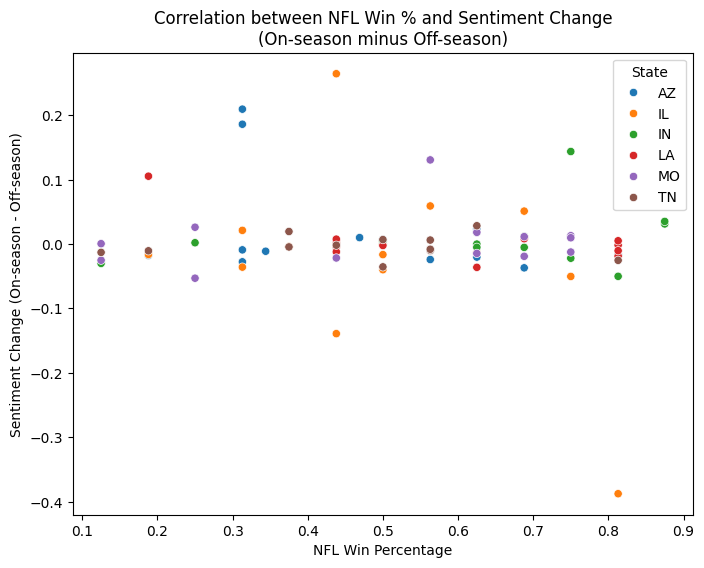

Correlation coefficient between NFL win percentage and sentiment change: -0.13616071406017366


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Group by state, season_start_year, and season_period to get average sentiment
# --------------------------
state_year_period_sentiment = review_sentiment_df.groupby(
    ['state', 'season_start_year', 'season_period']
).agg(
    avg_sentiment=('sentiment_polarity', 'mean')
).reset_index()

print("Grouped Sentiment Data:")
print(state_year_period_sentiment.head())

# --------------------------
# 2. Pivot the data so that each row is a state and season_start_year,
# with separate columns for on-season and off-season average sentiment
# --------------------------
sentiment_pivot = state_year_period_sentiment.pivot_table(
    index=['state', 'season_start_year'],
    columns='season_period',
    values='avg_sentiment'
).reset_index()

print("Pivoted Sentiment Data:")
print(sentiment_pivot.head())

# --------------------------
# 3. Compute the change in sentiment (on-season minus off-season)
# --------------------------
# Ensure the columns exist; if not, you may need to adjust your grouping logic
sentiment_pivot['sentiment_change'] = sentiment_pivot['on-season'] - sentiment_pivot['off-season']

# --------------------------
# 4. Merge with NFL performance data (nfl_df)
# Assuming:
# - review_sentiment_df's "season_start_year" corresponds to nfl_df's "year"
# - review_sentiment_df's "state" corresponds to nfl_df's "State"
# --------------------------
merged_df = pd.merge(
    sentiment_pivot,
    nfl_df,
    left_on=['state', 'season_start_year'],
    right_on=['State', 'year'],
    how='inner'
)

print("Merged Data:")
print(merged_df.head())

# --------------------------
# 5. Plot the relationship and compute correlation
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_df,
    x='win_loss_perc',
    y='sentiment_change',
    hue='state'
)
plt.title("Correlation between NFL Win % and Sentiment Change\n(On-season minus Off-season)")
plt.xlabel("NFL Win Percentage")
plt.ylabel("Sentiment Change (On-season - Off-season)")
plt.legend(title='State')
plt.show()

# Calculate and print the correlation coefficient between win percentage and sentiment change
corr_coef = merged_df['win_loss_perc'].corr(merged_df['sentiment_change'])
print("Correlation coefficient between NFL win percentage and sentiment change:", corr_coef)


On-season Sentiment Data:
  state  season_start_year  avg_on_season_sentiment
0    AZ               2004                 0.520612
1    AZ               2005                 0.744394
2    AZ               2006                 0.648856
3    AZ               2007                 0.626773
4    AZ               2008                 0.681365
Merged On-Season and NFL Data:
  state  season_start_year  avg_on_season_sentiment                new key  \
0    AZ               2005                 0.744394  2005Arizona Cardinals   
1    AZ               2006                 0.648856  2006Arizona Cardinals   
2    AZ               2007                 0.626773  2007Arizona Cardinals   
3    AZ               2008                 0.681365  2008Arizona Cardinals   
4    AZ               2009                 0.725238  2009Arizona Cardinals   

   year               team  win_loss_perc State  W/L Wildcard  W/L Divisional  \
0  2005  Arizona Cardinals          0.313    AZ             0               0   


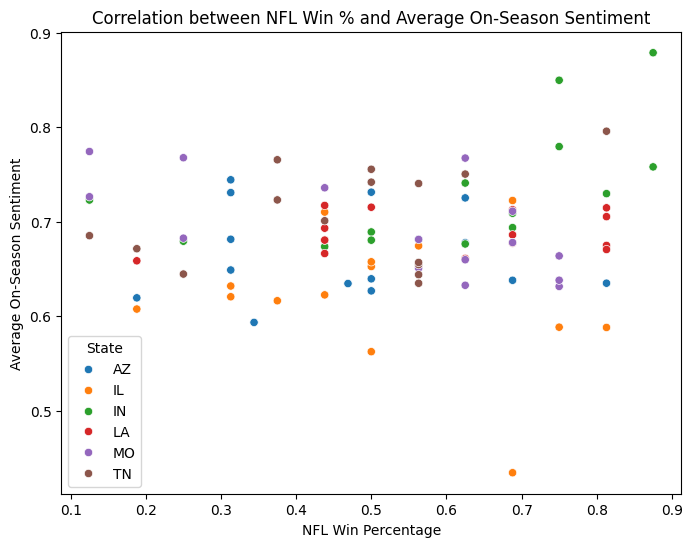

Correlation coefficient between NFL win percentage and on-season sentiment: 0.09106250082177836


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Filter for on-season reviews and group by state and season_start_year
# --------------------------
on_season_sentiment = review_sentiment_df[review_sentiment_df['season_period'] == 'on-season']
state_year_on_season = on_season_sentiment.groupby(
    ['state', 'season_start_year']
).agg(
    avg_on_season_sentiment=('sentiment_polarity', 'mean')
).reset_index()

print("On-season Sentiment Data:")
print(state_year_on_season.head())

# --------------------------
# 2. Merge the on-season sentiment data with NFL performance data (nfl_df)
# --------------------------
# Here we assume:
# - 'season_start_year' in review_sentiment_df corresponds to 'year' in nfl_df
# - 'state' in review_sentiment_df corresponds to 'State' in nfl_df
merged_on_season = pd.merge(
    state_year_on_season,
    nfl_df,
    left_on=['state', 'season_start_year'],
    right_on=['State', 'year'],
    how='inner'
)

print("Merged On-Season and NFL Data:")
print(merged_on_season.head())

# --------------------------
# 3. Plot the relationship and compute correlation
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_on_season,
    x='win_loss_perc',
    y='avg_on_season_sentiment',
    hue='state'
)
plt.title("Correlation between NFL Win % and Average On-Season Sentiment")
plt.xlabel("NFL Win Percentage")
plt.ylabel("Average On-Season Sentiment")
plt.legend(title='State')
plt.show()

# Calculate and print the correlation coefficient between win percentage and on-season sentiment
corr_coef = merged_on_season['win_loss_perc'].corr(merged_on_season['avg_on_season_sentiment'])
print("Correlation coefficient between NFL win percentage and on-season sentiment:", corr_coef)


Off-season Sentiment Data:
  state  season_start_year  avg_off_season_sentiment
0    AZ               2005                  0.558245
1    AZ               2006                  0.439270
2    AZ               2007                  0.626058
3    AZ               2008                  0.705340
4    AZ               2009                  0.702142
Merged Off-Season and NFL Data:
  state  season_start_year  avg_off_season_sentiment                new key  \
0    AZ               2005                  0.558245  2005Arizona Cardinals   
1    AZ               2006                  0.439270  2006Arizona Cardinals   
2    AZ               2007                  0.626058  2007Arizona Cardinals   
3    AZ               2008                  0.705340  2008Arizona Cardinals   
4    AZ               2009                  0.702142  2009Arizona Cardinals   

   year               team  win_loss_perc State  W/L Wildcard  W/L Divisional  \
0  2005  Arizona Cardinals          0.313    AZ             0      

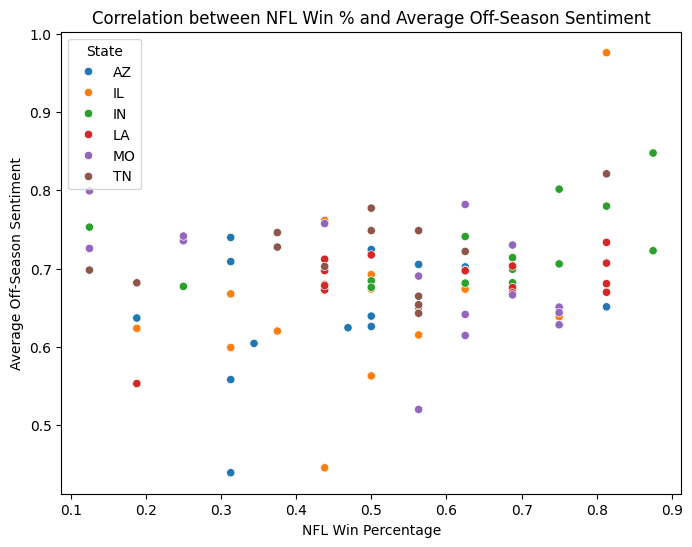

Correlation coefficient between NFL win percentage and off-season sentiment: 0.2205444895675059


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------
# 1. Filter for off-season reviews and group by state and season_start_year
# --------------------------
off_season_sentiment = review_sentiment_df[review_sentiment_df['season_period'] == 'off-season']
state_year_off_season = off_season_sentiment.groupby(
    ['state', 'season_start_year']
).agg(
    avg_off_season_sentiment=('sentiment_polarity', 'mean')
).reset_index()

print("Off-season Sentiment Data:")
print(state_year_off_season.head())

# --------------------------
# 2. Merge the off-season sentiment data with NFL performance data (nfl_df)
# --------------------------
# Assuming:
# - 'season_start_year' in review_sentiment_df corresponds to 'year' in nfl_df
# - 'state' in review_sentiment_df corresponds to 'State' in nfl_df
merged_off_season = pd.merge(
    state_year_off_season,
    nfl_df,
    left_on=['state', 'season_start_year'],
    right_on=['State', 'year'],
    how='inner'
)

print("Merged Off-Season and NFL Data:")
print(merged_off_season.head())

# --------------------------
# 3. Plot the relationship and compute correlation
# --------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=merged_off_season,
    x='win_loss_perc',
    y='avg_off_season_sentiment',
    hue='state'
)
plt.title("Correlation between NFL Win % and Average Off-Season Sentiment")
plt.xlabel("NFL Win Percentage")
plt.ylabel("Average Off-Season Sentiment")
plt.legend(title='State')
plt.show()

# Calculate and print the correlation coefficient between win percentage and off-season sentiment
corr_coef = merged_off_season['win_loss_perc'].corr(merged_off_season['avg_off_season_sentiment'])
print("Correlation coefficient between NFL win percentage and off-season sentiment:", corr_coef)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# --------------------------
# 1. Create On-Season Sentiment Data
# --------------------------
# Filter review_sentiment_df to only include on-season reviews
on_season_df = review_sentiment_df[review_sentiment_df['season_period'] == 'on-season']

# Group by state and season_start_year to compute the average on-season sentiment
state_year_on_season = on_season_df.groupby(['state', 'season_start_year']).agg(
    avg_on_season_sentiment=('sentiment_polarity', 'mean')
).reset_index()

# --------------------------
# 2. Prepare NFL Data
# --------------------------
# First, rename the playoff performance columns to remove spaces for easier reference
nfl_df_renamed = nfl_df.rename(columns={
    "W/L Wildcard": "wildcard",
    "W/L Divisional": "divisional",
    "W/L Conference": "conference",
    "W/L Superbowl": "superbowl"
})

# --------------------------
# 3. Merge On-Season Sentiment with NFL Performance Data
# --------------------------
# Assuming 'season_start_year' in state_year_on_season corresponds to 'year' in nfl_df_renamed
# and 'state' corresponds to 'State'
merged_on_season = pd.merge(
    state_year_on_season,
    nfl_df_renamed,
    left_on=['state', 'season_start_year'],
    right_on=['State', 'year'],
    how='inner'
)

print("Merged Data Sample:")
print(merged_on_season.head())

# --------------------------
# 4. Build the Regression Model
# --------------------------
# Here we build a model to predict average on-season sentiment
# using win percentage (win_loss_perc) and the playoff binary indicators.
# The model formula looks like this:
#   avg_on_season_sentiment ~ win_loss_perc + wildcard + divisional + conference + superbowl

model = smf.ols(
    formula='avg_on_season_sentiment ~ win_loss_perc + wildcard + divisional + conference + superbowl',
    data=merged_on_season
)
results = model.fit()

# Print the summary of the regression model
print(results.summary())


Merged Data Sample:
  state  season_start_year  avg_on_season_sentiment                new key  \
0    AZ               2005                 0.744394  2005Arizona Cardinals   
1    AZ               2006                 0.648856  2006Arizona Cardinals   
2    AZ               2007                 0.626773  2007Arizona Cardinals   
3    AZ               2008                 0.681365  2008Arizona Cardinals   
4    AZ               2009                 0.725238  2009Arizona Cardinals   

   year               team  win_loss_perc State  wildcard  divisional  \
0  2005  Arizona Cardinals          0.313    AZ         0           0   
1  2006  Arizona Cardinals          0.313    AZ         0           0   
2  2007  Arizona Cardinals          0.500    AZ         0           0   
3  2008  Arizona Cardinals          0.563    AZ         1           1   
4  2009  Arizona Cardinals          0.625    AZ         1           0   

   conference  superbowl  
0           0          0  
1           0     

Next, we would like to analyze if there are any noticeable differences in the text of the reviews between a high win % season and low win % season in the same city. For a starting point, we will look at the city that has the largest disparity between their highest and lowest win season, and analyze those years.

In [ ]:
import pandas as pd

# Original code to compute state win percentage disparities
state_win_diff = nfl_df.groupby('State')['win_loss_perc'].agg(['min', 'max']).reset_index()
state_win_diff['disparity'] = state_win_diff['max'] - state_win_diff['min']
state_win_diff = state_win_diff.sort_values('disparity', ascending=False)
second_largest = state_win_diff.iloc[1]

print("State with the second largest win percentage disparity:")
print(second_largest)

# Extract the target state and its min and max win percentages
target_state = second_largest['State']
min_win = second_largest['min']
max_win = second_largest['max']

# Now, look up the rows in nfl_df for the target state with these win percentages.
# These rows will show the years when the min and max win percentages occurred.
lookup_rows = nfl_df[(nfl_df['State'] == target_state) &
                     (nfl_df['win_loss_perc'].isin([min_win, max_win]))]

print("\nLookup rows for target state with min and max win percentages:")
print(lookup_rows)


State with the second largest win percentage disparity:
State           IN
min          0.125
max          0.875
disparity     0.75
Name: 3, dtype: object

Lookup rows for target state with min and max win percentages:
                   new key  year                team  win_loss_perc State  \
1   2005Indianapolis Colts  2005  Indianapolis Colts          0.875    IN   
45  2009Indianapolis Colts  2009  Indianapolis Colts          0.875    IN   
68  2011Indianapolis Colts  2011  Indianapolis Colts          0.125    IN   

    W/L Wildcard  W/L Divisional  W/L Conference  W/L Superbowl  
1              0               0               0              0  
45             1               1               1              0  
68             0               0               0              0  


Taking this analysis to SageMaker.